In [319]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [191]:
import warnings
warnings.filterwarnings('ignore')

# Stochastic Bandits

## Exploration Then Commit (ETC)

In [175]:
# a: the arm we choose to pull
# mu2: the true value of the mean for arm 2
def pullGaussian1(a,mu2):
        if a == 1:
            return np.random.normal(0,1)
        return np.random.normal(mu2,1)
    
def pullBernoulli1(a,p):
        if a == 1:
            p = 0.5
            return np.random.binomial(1,p)
        return np.random.binomial(1,p)

# m is the number of times we explore arm a
# n is the horizons or the number of times we play
# mu2 is the mean of arm bandit 2
def ETC(m,n,mu2,comment=False,gaussian=1):
    arm_means = [0,0]
    true_mean = [0,mu2]
    arm_pulls = [0,0]
    if gaussian == 1:
        mu1 = 0
        optimal = mu2 if mu2 > mu1 else mu1
    else:
        mu1 = 0.5
        optimal = mu2 if mu2 > mu1 else mu1
    
    # exploration phase
    exploration_regret = (optimal - mu2)*m + (optimal - mu1)*m
    
    if gaussian == 1:
        reward_1 = [pullGaussian1(1,mu2) for a in range(m)]
        reward_2 = [pullGaussian1(2,mu2) for a in range(m)]
    else:
        reward_1 = [pullBernoulli1(1,mu2) for a in range(m)]
        reward_2 = [pullBernoulli1(2,mu2) for a in range(m)]
    empirical_mean_1 = np.mean(reward_1)
    empirical_mean_2 = np.mean(reward_2)
    # exploitation phase
    best_mean = mu2 if empirical_mean_1 < empirical_mean_2 else mu1
    best_arm = 1 if empirical_mean_1 < empirical_mean_2 else 0
    if comment:
        print("arm1 mean:" + str(mu1))
        print("arm2 mean:" + str(mu2))
        print("best arm:" + str(best_arm))
        print("optimal arm:" + str(optimal))
    
    #reward_exploit = [pullGaussian(best_arm,mu2) for i in range(n - 2*m)]
    #reward = pullGaussian(best_arm,mu2)
    exploitation_regret = (optimal - best_mean)*(n-2*m)
    
        
    total_regret = exploitation_regret + exploration_regret
    
    if comment:
        print("exploration regret:" + str(exploration_regret))
        print("exploitation regret:" + str(exploitation_regret))
        print("total regret:" + str(total_regret))
        print("best arm true mean:" + str(true_mean[best_arm-1]))
        print("\n")
    
    
    return total_regret

In [140]:
# simulating ETC's N parameter
# Function takes in lists for m, n (horizon), and mu2 and
# performs a grid search of each set of parameters.
# Will ignore permutations where n <= m.
def simulationN_ETC(mu2,m,n=1000,num_sim=1000,gaussian=1):
    df = pd.DataFrame()
    df['mu2'] = mu2
    det = [determine_m(a) for a in mu2]
    for j in tqdm(m):            
        point_lst = []
        err_lst = []
        for i in tqdm(mu2):
            if j != 1000:
                simulation = [ETC(m=j,n=n,mu2=i,gaussian=gaussian) for a in range(num_sim)]
            else:
                simulation = [ETC(m=determine_m(i),n=n,mu2=i,gaussian=gaussian) for a in range(num_sim)]
            point = np.mean(simulation)
            err = np.var(simulation)
            point_lst += [point]
            err_lst += [err]
        
        df[str(j) + "point"] = point_lst
        df[str(j) + "error"] = err_lst
    return df

In [142]:
def determine_m(mu2):
    return int(max(1,np.ceil(4*np.log(250*mu2**2)/mu2**2)))

## Upper Confidence Bound Algorithms (UCB)

In [237]:
def pullGaussian(mu):
    return np.random.normal(mu,1)
    
def pullBernoulli(p):
    return np.random.binomial(1,p)

def simulationN_standard(mu2,n=1000,num_sim=1000,gaussian=True):
    point_lst = []
    var_lst = []
    df = pd.DataFrame()
    for m in tqdm(mu2):
        simulation = [UCB_standard(n=n,mu2=m,gaussian=1) for a in range(num_sim)]
        point = np.mean(simulation)
        var = np.var(simulation)
        point_lst += [point]
        var_lst += [var]
    df['point'] = point_lst
    df['var'] = var_lst
    return df

def simulationN_asymptotic(mu2,n=1000,num_sim=1000,gaussian=True):
    point_lst = []
    var_lst = []
    df = pd.DataFrame()
    for m in tqdm(mu2):
        simulation = [UCB_asymptotic(n=n,mu2=m,gaussian=1) for a in range(num_sim)]
        point = np.mean(simulation)
        var = np.var(simulation)
        point_lst += [point]
        var_lst += [var]
    df['point'] = point_lst
    df['var'] = var_lst
    return df

def simulationN_moss(mu2,n=1000,num_sim=1000,gaussian=True):
    point_lst = []
    var_lst = []
    df = pd.DataFrame()
    for m in tqdm(mu2):
        simulation = [UCB_moss(n=n,mu2=m,gaussian=1) for a in range(num_sim)]
        point = np.mean(simulation)
        var = np.var(simulation)
        point_lst += [point]
        var_lst += [var]
    df['point'] = point_lst
    df['var'] = var_lst
    return df

def simulationN_KL(mu2,n=1000,num_sim=1000,gaussian=True):
    point_lst = []
    var_lst = []
    df = pd.DataFrame()
    for m in tqdm(mu2):
        simulation = [UCB_KL(n=n,mu2=m,gaussian=1) for a in range(num_sim)]
        point = np.mean(simulation)
        var = np.var(simulation)
        point_lst += [point]
        var_lst += [var]
    df['point'] = point_lst
    df['var'] = var_lst
    return df

In [238]:
def UCB_standard(n,mu2,gaussian=1):
    if mu2 == 0:
        return 0
    reward = [pullGaussian(0),pullGaussian(mu2)] if gaussian else [pullBernoulli(0),pullBernoulli(mu2)]
    rewards1 = [reward[0]]
    rewards2 = [reward[1]]
    ti = [1,1]
    t = 2
    regret = 0
    optimal = 0 if mu2 < 0 else 1
    
    while(t < n):
        ucb = [np.mean(rewards1) + np.sqrt(2*np.log(n**2)/ti[0]),np.mean(rewards2) + np.sqrt(2*np.log(n**2)/ti[1])]
        argmax = np.argmax(ucb)
        reward = [pullGaussian(0),pullGaussian(mu2)] if gaussian else [pullBernoulli(0),pullBernoulli(mu2)]
        
        if argmax == 0:
            rewards1 += [reward[0]]
        else:
            rewards2 += [reward[1]]
        ti[argmax] += 1
        t+=1
        regret += 0 if optimal == argmax else mu2
    
    return regret

In [239]:
def UCB_asymptotic(n,mu2,gaussian=1):
    if mu2 == 0:
        return 0
    reward = [pullGaussian(0),pullGaussian(mu2)] if gaussian else [pullBernoulli(0),pullBernoulli(mu2)]
    rewards1 = [reward[0]]
    rewards2 = [reward[1]]
    ti = [1,1]
    t = 2
    regret = 0
    optimal = 0 if mu2 < 0 else 1
    
    while(t < n):
        ft = np.log(1 + t*np.log(np.log(t)))
        ucb = [np.mean(rewards1) + np.sqrt(2*ft/ti[0]),np.mean(rewards2) + np.sqrt(2*ft/ti[1])]
        argmax = np.argmax(ucb)
        reward = [pullGaussian(0),pullGaussian(mu2)] if gaussian else [pullBernoulli(0),pullBernoulli(mu2)]
        
        if argmax == 0:
            rewards1 += [reward[0]]
        else:
            rewards2 += [reward[1]]
        ti[argmax] += 1
        t+=1
        regret += 0 if optimal == argmax else mu2
    
    return regret

In [240]:
def log_plus(n,t):
    x = n / (2  *t)
    return max(np.log(1),np.log(x))

def UCB_moss(n,mu2,gaussian=1):
    if mu2 == 0: 
        return 0
    reward = [pullGaussian(0),pullGaussian(mu2)] if gaussian else [pullBernoulli(0),pullBernoulli(mu2)]
    rewards1 = [reward[0]]
    rewards2 = [reward[1]]
    ti = [1,1]
    t = 2
    regret = 0
    optimal = 0 if mu2 < 0 else 1
    
    while(t < n):
        if t != 1:
            ft = 1 + t*np.log(t)*np.log(t)
            
        ucb = [np.mean(rewards1) + np.sqrt((4/ti[0])*log_plus(n,ti[0])),np.mean(rewards2) + np.sqrt((4/ti[1])*log_plus(n,ti[1]))]
        argmax = np.argmax(ucb)
        reward = [pullGaussian(0),pullGaussian(mu2)] if gaussian else [pullBernoulli(0),pullBernoulli(mu2)]
        
        if argmax == 0:
            rewards1 += [reward[0]]
        else:
            rewards2 += [reward[1]]
        ti[argmax] += 1
        t+=1
        regret += 0 if optimal == argmax else mu2
    
    return regret

In [271]:
def d(p,q):
    if (p == 0):
        if (q < 1 and q > 0):
            return np.log(1/(1-q))
        else:
            return 0
    if (p == 1):
        if (q < 1 and q > 0):
            return np.log(1/q)
        else:
            return 1
    return p*np.log(p/q) + (1-p)*np.log((1-p)/(1-q))

def calculate_ucb(p,t,ti):
    ft = 1 + t*(np.log(np.log(t)))
    upper_bound = np.log(ft) / ti
    bounds = [p,1]
    for i in range(10):
       
        half = (sum(bounds)) / 2
        if bounds[1]-bounds[0] < 1e-5:
             #early stopping
            break
        
        entropy = d(p,half)

        if entropy < upper_bound:
            bounds[0] = half
        else:
            bounds[1] = half

    return half

def UCB_KL(n,mu2,gaussian=1):
    if mu2 == 0.5:
        return 0
    reward = [pullBernoulli(0.5),pullBernoulli(mu2)]
    rewards1 = [reward[0]]
    rewards2 = [reward[1]]
    ti = [1,1]
    t = 2
    regret = 0
    optimal = 0 if mu2 < 0.5 else 1
    
    while(t < n): 
        #ucb = calculate_ucb(np.array([np.mean(rewards1),np.mean(rewards2)]),t,ti[0])
        ucb = [calculate_ucb(np.mean(rewards1),t,ti[0]),calculate_ucb(np.mean(rewards2),t,ti[1])]
        print(ucb)
        argmax = np.argmax(ucb)
        
        reward = [pullBernoulli(0.5),pullBernoulli(mu2)]
        
        if argmax == 0:
            rewards1 += [reward[0]]
        else:
            rewards2 += [reward[1]]
        ti[argmax] += 1
        t+=1
        regret += 0 if optimal == argmax else abs(mu2-0.5)
    
    return regret

In [275]:
UCB_KL(1000,0.7)

[0.0009765625, 0.0009765625]
[0.1162109375, 0.2197265625]
[0.3408203125, 0.3408203125]
[0.3330078125, 0.4560546875]
[0.3935546875, 0.3935546875]
[0.3525390625, 0.4384765625]
[0.3818359375, 0.3818359375]
[0.6460937499999999, 0.4072265625]
[0.7454427083333333, 0.4287109375]
[0.6868024553571428, 0.4462890625]
[0.635986328125, 0.4619140625]
[0.5936414930555556, 0.4755859375]
[0.65888671875, 0.4892578125]
[0.6228693181818181, 0.4990234375]
[0.6712239583333333, 0.5107421875]
[0.6382962740384617, 0.5185546875]
[0.6086774553571428, 0.5283203125]
[0.5824869791666665, 0.5361328125]
[0.558349609375, 0.5439453125]
[0.5362477022058822, 0.5498046875]
[0.5377412683823528, 0.7445312500000001]
[0.5407284007352942, 0.8131510416666666]
[0.5437155330882353, 0.8532366071428572]
[0.5452090992647058, 0.87841796875]
[0.548196231617647, 0.831271701388889]
[0.5496897977941175, 0.7873046874999999]
[0.5526769301470589, 0.8140980113636365]
[0.5541704963235294, 0.83544921875]
[0.5556640625, 0.8526141826923076]
[0.5

[0.6661879595588236, 0.7969097884860051]
[0.6661879595588236, 0.7974252458756346]
[0.6661879595588236, 0.7979380933544302]
[0.6661879595588236, 0.7984483506944446]
[0.6661879595588236, 0.7971283650818639]
[0.6661879595588236, 0.7976380928077889]
[0.6661879595588236, 0.7981452655075187]
[0.6661879595588236, 0.7986499023437501]
[0.6661879595588236, 0.79915202228803]
[0.6661879595588236, 0.7973025497512438]
[0.6661879595588236, 0.7978055210918115]
[0.6661879595588236, 0.7983060024752475]
[0.6661879595588236, 0.7970076195987655]
[0.6661879595588236, 0.7975076008312808]
[0.6676815257352942, 0.7980051251535627]
[0.6676815257352942, 0.7985002106311275]
[0.6676815257352942, 0.7989928751528117]
[0.6676815257352942, 0.7994831364329267]
[0.6676815257352942, 0.7976591012773724]
[0.6676815257352942, 0.7981502199635923]
[0.6676815257352942, 0.7968726354418887]
[0.6676815257352942, 0.7973632812500002]
[0.6676815257352942, 0.7978515625000001]
[0.6676815257352942, 0.7960392878605769]
[0.667681525735294

[0.6856043198529413, 0.7680670651990553]
[0.6856043198529413, 0.7683796432783019]
[0.6856043198529413, 0.7670523847577388]
[0.6856043198529413, 0.7679377730174732]
[0.6856043198529413, 0.7666120490771812]
[0.6856043198529413, 0.7669249015583111]
[0.6856043198529413, 0.7661740712851404]
[0.6856043198529413, 0.7664866727941178]
[0.6856043198529413, 0.7657384324933243]
[0.6856043198529413, 0.7660507812499999]
[0.6856043198529413, 0.7663622981857523]
[0.6856043198529413, 0.7666729866190161]
[0.6856043198529413, 0.7669828498505975]
[0.6856043198529413, 0.7662389132957559]
[0.6856043198529413, 0.766548530629139]
[0.6856043198529413, 0.7668573288690477]
[0.6856043198529413, 0.7671653112615588]
[0.6856043198529413, 0.765850459680079]
[0.6856043198529413, 0.7661589570981555]
[0.6856043198529413, 0.7670397306743422]
[0.6856043198529413, 0.7673458545499342]
[0.6856043198529413, 0.7676511749507873]
[0.6856043198529413, 0.7679556950360419]
[0.6856043198529413, 0.7666475785340314]
[0.685604319852941

3.2

In [ ]:
df4 = simulationN_KL(mu2_fast,num_sim=1000)

## Thompson Sampling

In [ ]:
def simulationN_TS1(mu2,p1,p2,n=1000,num_sim=1000):
    point_lst = []
    var_lst = []
    for i in tqdm(mu2):
        simulation = [thompson_sampling_gaussian(n=n,mu2=i,p1=p1,p2=p2) for a in range(num_sim)]
        point = np.mean(simulation)
        print(point)
        var = np.var(simulation)
        point_lst += [point]
        var_lst += [var]
    df = pd.DataFrame()
    df['mu2'] = mu2
    df['regret'] = point_lst
    df['var'] = var_lst
    return df

def simulation_TS2(mu2,p1,p2,n=1000,num_sim=1000):
    point_lst = []
    var_lst = []
    for i in tqdm(mu2):
        simulation = [thompson_sampling_bernoulli(n=n,mu2=i,p1=p1,p2=p2) for a in range(num_sim)]
        point = np.mean(simulation)
        print(point)
        var = np.var(simulation)
        point_lst += [point]
        var_lst += [var]
    df = pd.DataFrame()
    df['mu2'] = mu2
    df['regret'] = point_lst
    df['var'] = var_lst
    return df

In [246]:
def calculate_regret(n,opt_mu,mus):
    rn = n*opt_mu - sum(mus)
    
def calculate_posterior_value_gaussian(x,sigma,mup,sigmap,n):
    # x is the observed sample mean
    # sigma is the signal std
    # mup is the mean of the prior
    # sigmap is the std of the prior
    # n is the number of simulated values to get
    mean = ((mup / (sigmap)**2) + (np.mean(x)/(sigma)**2)) / ((1/(sigmap)**2) + (1/(sigma)**2))
    std = ((1/(sigmap)**2) + (1/(sigma)**2))**(-1)
    #std = 1/((1/(sigmap)**2) + n)
    #mean = std*sum(x)
    return [mean,std**(0.5)]

def pullGaussian(mu,sigma):
        return np.random.normal(mu,sigma)
    
def thompson_sampling_gaussian(n,mu2,p1,p2):
    # n is the horizon (number of iterations)
    # mu2 is the true mean of bandit 2
    # p1 is the prior distribution for bandit 1
    # p2 is the prior distriubtion for bandit 2
    t = 1
    regret = 0
    rewards1 = []
    rewards2 = []
    visits = [0,0]
    dist1 = p1
    dist2 = p2
    if mu2 > 0: 
        opt_mu = mu2
    else:
        opt_mu = 0
    
    while(t < n):
        
        # Sampling v_{t}
        sim1 = np.random.normal(dist1[0],dist1[1])
        sim2 = np.random.normal(dist2[0],dist2[1])

        # Choosing At
        arm = np.argmax([sim1,sim2])
        
        # pull reward and update distribution
        if arm == 0: # Choose arm 1
            reward = pullGaussian(0,1)
            rewards1 += [reward]
            regret += abs((opt_mu - 0))
            visits[0] += 1
            dist1 = calculate_posterior_value_gaussian(rewards1,1,dist1[0],dist1[1],visits[0])
        else: # Choose arm 2
            reward = pullGaussian(mu2,1)
            rewards2 += [reward]
            regret += abs(opt_mu-mu2)
            visits[1] += 1
            #print(dist2)
            dist2 = calculate_posterior_value_gaussian(rewards2,1,dist2[0],dist2[1],visits[1])
        t += 1
    return regret

def calculate_posterior_value_bernoulli(x,alpha,beta):
    # x is the observed sample mean
    # sigma is the signal std
    # mup is the mean of the prior
    # sigmap is the std of the prior
    # n is the number of simulated values to get
    return [alpha+np.mean(x),beta+1-np.mean(x)]

def pullBernoulli(p):
        return np.random.binomial(1,p)
    
def thompson_sampling_bernoulli(n,mu2,p1,p2):
    # n is the horizon (number of iterations)
    # mu2 is the true mean of bandit 2
    # p1 is the prior distribution for bandit 1
    # p2 is the prior distriubtion for bandit 2
    t = 1
    regret = 0
    dist1 = p1
    dist2 = p2
    rewards1 = []
    rewards2 = []
    visits = [0,0]
    if mu2 > 0: 
        opt_mu = mu2
    else:
        opt_mu = 0.5
    
    while(t < n):
        
        # Sampling v_{t}
        sim1 = np.random.beta(dist1[0],dist1[1])
        sim2 = np.random.beta(dist2[0],dist2[1])

        # Choosing At
        arm = np.argmax([sim1,sim2])
        
        
        # pull reward and update distribution
        if arm == 0: # Choose arm 1
            reward = pullBernoulli(dist1[0] / (dist1[0] + dist1[1]))
            regret += abs((opt_mu - 0.5))
            rewards1 += [reward]
            dist1 = calculate_posterior_value_bernoulli(rewards1,dist1[0],dist1[1])
        else: # Choose arm 2
            reward = pullBernoulli(dist2[0] / (dist2[0] + dist2[1]))
            regret += abs(opt_mu-mu2)
            rewards2 += [reward]
            dist1 = calculate_posterior_value_bernoulli(rewards2,dist2[0],dist2[1])
        t += 1
    return regret

# Linear Bandits

In [312]:
def UCB_Linear(a,n,theta,lamb=0.1):
    delta = 1/n
    mu_hat = 0
    theta_hat = 0
    ti = [0,0]
    rewards1 = []
    rewards2 = []
    t = 1
    regret = 0
    V = lamb
    at = [a[0]*theta,a[1]*theta]
    optimal = a[np.argmax(at)]
    while(t < n): 
        beta = np.sqrt(lamb) + np.sqrt(2*np.log(1/delta) + np.log((1+(t-1))/delta))
        a_hat = [0,0]
        for i in range(2):
            a_hat[i] = a[i]*theta_hat + beta*np.sqrt(a[i]**(2)/lamb)
        argmax = np.argmax(a_hat)
        reward = theta*a[argmax] + np.random.normal(0,1)
        V = V + a[argmax]**2
        
        mu_hat = mu_hat + reward*a[argmax]
        theta_hat = mu_hat / V
        ti[argmax] += 1
        t+=1
        regret_t = 0 if a[argmax] == optimal else (optimal-a[argmax])*theta
        regret+= regret_t
    
    return regret

def simulationN_LinUCB(a,theta,n=1000,num_sim=1000):
    point_lst = []
    var_lst = []
    df = pd.DataFrame()
    for t in tqdm(theta):
        simulation = [UCB_Linear(a,n,t) for b in range(num_sim)]
        point = np.mean(simulation)
        var = np.var(simulation)
        print(point)
        point_lst += [point]
        var_lst += [var]
    df['point'] = point_lst
    df['var'] = var_lst
    return df

def simulationN_TSLin(a,theta,n=1000,num_sim=1000):
    point_lst = []
    var_lst = []
    df = pd.DataFrame()
    for t in tqdm(theta):
        simulation = [thompsonSampling_linear(a,n,t) for b in range(num_sim)]
        point = np.mean(simulation)
        var = np.var(simulation)
        print(point)
        point_lst += [point]
        var_lst += [var]
    df['point'] = point_lst
    df['var'] = var_lst
    return df

def thompsonSampling_linear(a,n,theta):
    mu_t = 0
    sigma_t = 1
    regret = 0
    at = [a[0]*theta,a[1]*theta]
    optimal = a[np.argmax(at)]
    choose = [0,0]
    #print(optimal)
    
    for i in range(n):
        theta_hat = np.random.normal(mu_t, sigma_t)
        #print(theta_hat)
        X_t = [a[0]*theta_hat,a[1]*theta_hat]
        action = np.argmax(X_t)
        #print([action])
        #print(optimal)
        regret_t = 0 if a[action] == optimal else (a[action]-optimal)*theta
        #print(regret_t)
        regret += regret_t
        choose[action]+=1
        
        reward = theta*a[action] + np.random.normal(0,1) # noise
        sigma_t1 = sigma_t / ((X_t[action]**(2))*sigma_t + 1)
        mu_t1 = sigma_t1*(mu_t/sigma_t + X_t[action]*reward)
        mu_t = mu_t1
        sigma_t = sigma_t1
    #print(mu_t)
    #print(sigma_t)
    #print(choose)
    return regret

In [288]:
theta1 = [0.01*x for x in range(-50,51)]

In [315]:
x1 = simulationN_LinUCB([0.1,-0.2],theta1,n=1000,num_sim=100)

  1%|▊                                                                                 | 1/101 [00:02<03:45,  2.25s/it]

0.0


  2%|█▌                                                                                | 2/101 [00:04<03:30,  2.12s/it]

0.0


  3%|██▍                                                                               | 3/101 [00:06<03:23,  2.08s/it]

0.00288


  4%|███▏                                                                              | 4/101 [00:08<03:26,  2.13s/it]

0.0


  5%|████                                                                              | 5/101 [00:10<03:29,  2.18s/it]

0.0


  6%|████▊                                                                             | 6/101 [00:12<03:27,  2.18s/it]

0.0


  7%|█████▋                                                                            | 7/101 [00:15<03:23,  2.16s/it]

0.0


  8%|██████▍                                                                           | 8/101 [00:17<03:21,  2.17s/it]

0.0012900000000000001


  9%|███████▎                                                                          | 9/101 [00:19<03:15,  2.13s/it]

0.00378


 10%|████████                                                                         | 10/101 [00:21<03:13,  2.13s/it]

0.0


 11%|████████▊                                                                        | 11/101 [00:23<03:14,  2.16s/it]

0.0


 12%|█████████▌                                                                       | 12/101 [00:26<03:17,  2.22s/it]

0.0


 13%|██████████▍                                                                      | 13/101 [00:28<03:15,  2.22s/it]

0.0


 14%|███████████▏                                                                     | 14/101 [00:30<03:14,  2.24s/it]

0.0


 15%|████████████                                                                     | 15/101 [00:32<03:16,  2.28s/it]

0.0


 16%|████████████▊                                                                    | 16/101 [00:35<03:18,  2.34s/it]

0.0


 17%|█████████████▋                                                                   | 17/101 [00:37<03:16,  2.34s/it]

0.0


 18%|██████████████▍                                                                  | 18/101 [00:40<03:17,  2.38s/it]

0.0


 19%|███████████████▏                                                                 | 19/101 [00:42<03:14,  2.37s/it]

0.0


 20%|████████████████                                                                 | 20/101 [00:44<03:07,  2.31s/it]

0.0


 21%|████████████████▊                                                                | 21/101 [00:47<03:07,  2.34s/it]

0.0


 22%|█████████████████▋                                                               | 22/101 [00:49<02:59,  2.28s/it]

0.0


 23%|██████████████████▍                                                              | 23/101 [00:51<02:56,  2.26s/it]

0.0


 24%|███████████████████▏                                                             | 24/101 [00:53<02:53,  2.25s/it]

0.0


 25%|████████████████████                                                             | 25/101 [00:55<02:48,  2.22s/it]

0.0


 26%|████████████████████▊                                                            | 26/101 [00:58<02:49,  2.26s/it]

0.0


 27%|█████████████████████▋                                                           | 27/101 [01:00<02:53,  2.34s/it]

0.0


 28%|██████████████████████▍                                                          | 28/101 [01:03<02:59,  2.46s/it]

0.004140000000000001


 29%|███████████████████████▎                                                         | 29/101 [01:06<03:00,  2.50s/it]

0.0


 30%|████████████████████████                                                         | 30/101 [01:08<02:53,  2.45s/it]

0.0


 31%|████████████████████████▊                                                        | 31/101 [01:10<02:44,  2.35s/it]

0.0


 32%|█████████████████████████▋                                                       | 32/101 [01:12<02:36,  2.27s/it]

0.0


 33%|██████████████████████████▍                                                      | 33/101 [01:14<02:33,  2.26s/it]

0.0


 34%|███████████████████████████▎                                                     | 34/101 [01:17<02:30,  2.24s/it]

0.0


 35%|████████████████████████████                                                     | 35/101 [01:19<02:33,  2.32s/it]

0.0


 36%|████████████████████████████▊                                                    | 36/101 [01:21<02:30,  2.32s/it]

0.0


 37%|█████████████████████████████▋                                                   | 37/101 [01:24<02:28,  2.32s/it]

0.00042000000000000007


 38%|██████████████████████████████▍                                                  | 38/101 [01:26<02:26,  2.33s/it]

0.0


 39%|███████████████████████████████▎                                                 | 39/101 [01:28<02:22,  2.29s/it]

0.0


 40%|████████████████████████████████                                                 | 40/101 [01:31<02:21,  2.32s/it]

0.0


 41%|████████████████████████████████▉                                                | 41/101 [01:33<02:21,  2.35s/it]

0.0


 42%|█████████████████████████████████▋                                               | 42/101 [01:36<02:20,  2.38s/it]

0.0


 43%|██████████████████████████████████▍                                              | 43/101 [01:38<02:12,  2.29s/it]

0.0


 44%|███████████████████████████████████▎                                             | 44/101 [01:40<02:06,  2.22s/it]

0.0


 45%|████████████████████████████████████                                             | 45/101 [01:42<02:01,  2.18s/it]

0.0


 46%|████████████████████████████████████▉                                            | 46/101 [01:44<01:57,  2.13s/it]

0.0


 47%|█████████████████████████████████████▋                                           | 47/101 [01:46<01:54,  2.11s/it]

0.0


 48%|██████████████████████████████████████▍                                          | 48/101 [01:48<01:50,  2.09s/it]

0.0


 49%|███████████████████████████████████████▎                                         | 49/101 [01:50<01:47,  2.07s/it]

0.0


 50%|████████████████████████████████████████                                         | 50/101 [01:52<01:45,  2.08s/it]

0.0


 50%|████████████████████████████████████████▉                                        | 51/101 [01:54<01:45,  2.11s/it]

0.0


 51%|█████████████████████████████████████████▋                                       | 52/101 [01:56<01:42,  2.08s/it]

2.9970000000000034


 52%|██████████████████████████████████████████▌                                      | 53/101 [01:58<01:39,  2.07s/it]

5.994000000000007


 53%|███████████████████████████████████████████▎                                     | 54/101 [02:00<01:37,  2.08s/it]

8.991000000000158


 54%|████████████████████████████████████████████                                     | 55/101 [02:02<01:35,  2.07s/it]

11.988000000000014


 55%|████████████████████████████████████████████▉                                    | 56/101 [02:04<01:32,  2.05s/it]

14.984850000000183


 56%|█████████████████████████████████████████████▋                                   | 57/101 [02:06<01:30,  2.05s/it]

17.982000000000316


 57%|██████████████████████████████████████████████▌                                  | 58/101 [02:08<01:28,  2.05s/it]

20.97900000000046


 58%|███████████████████████████████████████████████▎                                 | 59/101 [02:11<01:27,  2.09s/it]

23.976000000000028


 59%|████████████████████████████████████████████████                                 | 60/101 [02:13<01:25,  2.08s/it]

26.97300000000023


 60%|████████████████████████████████████████████████▉                                | 61/101 [02:15<01:26,  2.15s/it]

29.969700000000365


 61%|█████████████████████████████████████████████████▋                               | 62/101 [02:17<01:26,  2.23s/it]

32.96700000000055


 62%|██████████████████████████████████████████████████▌                              | 63/101 [02:20<01:28,  2.32s/it]

35.96400000000063


 63%|███████████████████████████████████████████████████▎                             | 64/101 [02:22<01:27,  2.38s/it]

38.96100000000079


 64%|████████████████████████████████████████████████████▏                            | 65/101 [02:25<01:26,  2.39s/it]

41.95800000000092


 65%|████████████████████████████████████████████████████▉                            | 66/101 [02:27<01:22,  2.37s/it]

44.95455000000106


 66%|█████████████████████████████████████████████████████▋                           | 67/101 [02:30<01:19,  2.35s/it]

47.952000000000055


 67%|██████████████████████████████████████████████████████▌                          | 68/101 [02:32<01:17,  2.35s/it]

50.948490000000255


 68%|███████████████████████████████████████████████████████▎                         | 69/101 [02:34<01:16,  2.39s/it]

53.94600000000046


 69%|████████████████████████████████████████████████████████▏                        | 70/101 [02:37<01:13,  2.38s/it]

56.94300000000062


 70%|████████████████████████████████████████████████████████▉                        | 71/101 [02:39<01:09,  2.32s/it]

59.94000000000074


 71%|█████████████████████████████████████████████████████████▋                       | 72/101 [02:41<01:06,  2.30s/it]

62.93700000000093


 72%|██████████████████████████████████████████████████████████▌                      | 73/101 [02:43<01:03,  2.26s/it]

65.9340000000011


 73%|███████████████████████████████████████████████████████████▎                     | 74/101 [02:45<00:59,  2.20s/it]

68.93100000000129


 74%|████████████████████████████████████████████████████████████▏                    | 75/101 [02:47<00:55,  2.15s/it]

71.92800000000126


 75%|████████████████████████████████████████████████████████████▉                    | 76/101 [02:50<00:54,  2.17s/it]

74.9250000000014


 76%|█████████████████████████████████████████████████████████████▊                   | 77/101 [02:52<00:51,  2.16s/it]

77.91030000000157


 77%|██████████████████████████████████████████████████████████████▌                  | 78/101 [02:54<00:51,  2.24s/it]

80.91900000000172


 78%|███████████████████████████████████████████████████████████████▎                 | 79/101 [02:57<00:50,  2.28s/it]

83.91516000000185


 79%|████████████████████████████████████████████████████████████████▏                | 80/101 [02:59<00:48,  2.33s/it]

86.90778000000202


 80%|████████████████████████████████████████████████████████████████▉                | 81/101 [03:01<00:46,  2.34s/it]

89.91000000000213


 81%|█████████████████████████████████████████████████████████████████▊               | 82/101 [03:04<00:44,  2.35s/it]

92.90700000000231


 82%|██████████████████████████████████████████████████████████████████▌              | 83/101 [03:06<00:42,  2.35s/it]

95.90400000000011


 83%|███████████████████████████████████████████████████████████████████▎             | 84/101 [03:08<00:39,  2.34s/it]

98.90100000000028


 84%|████████████████████████████████████████████████████████████████████▏            | 85/101 [03:11<00:37,  2.34s/it]

101.89800000000052


 85%|████████████████████████████████████████████████████████████████████▉            | 86/101 [03:13<00:35,  2.36s/it]

104.89500000000068


 86%|█████████████████████████████████████████████████████████████████████▊           | 87/101 [03:16<00:33,  2.42s/it]

107.88012000000091


 87%|██████████████████████████████████████████████████████████████████████▌          | 88/101 [03:18<00:31,  2.45s/it]

110.88900000000105


 88%|███████████████████████████████████████████████████████████████████████▍         | 89/101 [03:21<00:30,  2.51s/it]

113.88600000000125


 89%|████████████████████████████████████████████████████████████████████████▏        | 90/101 [03:23<00:27,  2.49s/it]

116.88300000000143


 90%|████████████████████████████████████████████████████████████████████████▉        | 91/101 [03:26<00:24,  2.46s/it]

119.88000000000147


 91%|█████████████████████████████████████████████████████████████████████████▊       | 92/101 [03:28<00:21,  2.38s/it]

122.87700000000173


 92%|██████████████████████████████████████████████████████████████████████████▌      | 93/101 [03:30<00:18,  2.31s/it]

125.86896000000186


 93%|███████████████████████████████████████████████████████████████████████████▍     | 94/101 [03:33<00:16,  2.34s/it]

128.87100000000197


 94%|████████████████████████████████████████████████████████████████████████████▏    | 95/101 [03:35<00:14,  2.33s/it]

131.8680000000022


 95%|████████████████████████████████████████████████████████████████████████████▉    | 96/101 [03:37<00:11,  2.31s/it]

134.86500000000163


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 97/101 [03:39<00:09,  2.26s/it]

137.86200000000258


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 98/101 [03:41<00:06,  2.22s/it]

140.8519500000015


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 99/101 [03:44<00:04,  2.23s/it]

143.85600000000252


 99%|███████████████████████████████████████████████████████████████████████████████▏| 100/101 [03:46<00:02,  2.21s/it]

146.8530000000008


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [03:48<00:00,  2.26s/it]

149.84850000000282


In [317]:
x = simulationN_TSLin([0.1,-0.2],theta1,n=1000,num_sim=100)

  1%|▊                                                                                 | 1/101 [00:01<02:51,  1.71s/it]

51.907499999999864


  2%|█▌                                                                                | 2/101 [00:03<02:52,  1.75s/it]

50.10053999999982


  3%|██▍                                                                               | 3/101 [00:05<02:57,  1.81s/it]

52.5556799999998


  4%|███▏                                                                              | 4/101 [00:07<02:56,  1.82s/it]

45.2257500000001


  5%|████                                                                              | 5/101 [00:09<03:00,  1.88s/it]

45.79944000000004


  6%|████▊                                                                             | 6/101 [00:11<03:00,  1.90s/it]

44.24624999999999


  7%|█████▋                                                                            | 7/101 [00:12<02:56,  1.87s/it]

45.01068000000001


  8%|██████▍                                                                           | 8/101 [00:14<02:50,  1.83s/it]

44.787510000000005


  9%|███████▎                                                                          | 9/101 [00:16<02:46,  1.81s/it]

46.58723999999996


 10%|████████                                                                         | 10/101 [00:18<02:42,  1.78s/it]

42.44729999999995


 11%|████████▊                                                                        | 11/101 [00:19<02:39,  1.77s/it]

43.298399999999894


 12%|█████████▌                                                                       | 12/101 [00:21<02:33,  1.72s/it]

40.72301999999999


 13%|██████████▍                                                                      | 13/101 [00:23<02:31,  1.72s/it]

39.5910599999999


 14%|███████████▏                                                                     | 14/101 [00:24<02:26,  1.69s/it]

40.85354999999987


 15%|████████████                                                                     | 15/101 [00:26<02:25,  1.69s/it]

36.7837199999999


 16%|████████████▊                                                                    | 16/101 [00:28<02:23,  1.68s/it]

37.80629999999983


 17%|█████████████▋                                                                   | 17/101 [00:29<02:20,  1.68s/it]

35.265479999999854


 18%|██████████████▍                                                                  | 18/101 [00:31<02:18,  1.67s/it]

34.89650999999983


 19%|███████████████▏                                                                 | 19/101 [00:33<02:16,  1.66s/it]

36.44351999999974


 20%|████████████████                                                                 | 20/101 [00:34<02:15,  1.68s/it]

38.515950000000366


 21%|████████████████▊                                                                | 21/101 [00:36<02:14,  1.68s/it]

33.471000000000224


 22%|█████████████████▋                                                               | 22/101 [00:38<02:11,  1.67s/it]

33.19746000000023


 23%|██████████████████▍                                                              | 23/101 [00:39<02:10,  1.67s/it]

32.27700000000015


 24%|███████████████████▏                                                             | 24/101 [00:41<02:08,  1.67s/it]

31.279770000000166


 25%|████████████████████                                                             | 25/101 [00:43<02:07,  1.68s/it]

29.51364000000008


 26%|████████████████████▊                                                            | 26/101 [00:45<02:07,  1.69s/it]

29.589000000000052


 27%|█████████████████████▋                                                           | 27/101 [00:46<02:08,  1.73s/it]

28.666799999999984


 28%|██████████████████████▍                                                          | 28/101 [00:48<02:08,  1.76s/it]

26.8575600000001


 29%|███████████████████████▎                                                         | 29/101 [00:50<02:04,  1.72s/it]

27.67182000000009


 30%|████████████████████████                                                         | 30/101 [00:51<02:01,  1.71s/it]

25.367580000000043


 31%|████████████████████████▊                                                        | 31/101 [00:53<01:58,  1.70s/it]

23.336999999999957


 32%|█████████████████████████▋                                                       | 32/101 [00:55<01:56,  1.69s/it]

21.536309999999993


 33%|██████████████████████████▍                                                      | 33/101 [00:57<01:55,  1.70s/it]

22.050359999999937


 34%|███████████████████████████▎                                                     | 34/101 [00:58<01:53,  1.69s/it]

21.8698199999999


 35%|████████████████████████████                                                     | 35/101 [01:00<01:50,  1.68s/it]

21.536639999999817


 36%|████████████████████████████▊                                                    | 36/101 [01:01<01:48,  1.67s/it]

18.4027500000002


 37%|█████████████████████████████▋                                                   | 37/101 [01:03<01:49,  1.70s/it]

15.308580000000081


 38%|██████████████████████████████▍                                                  | 38/101 [01:05<01:50,  1.75s/it]

17.82261000000011


 39%|███████████████████████████████▎                                                 | 39/101 [01:07<01:48,  1.75s/it]

16.496280000000056


 40%|████████████████████████████████                                                 | 40/101 [01:09<01:48,  1.78s/it]

13.656390000000059


 41%|████████████████████████████████▉                                                | 41/101 [01:11<01:50,  1.84s/it]

12.130199999999995


 42%|█████████████████████████████████▋                                               | 42/101 [01:12<01:47,  1.82s/it]

11.651039999999984


 43%|██████████████████████████████████▍                                              | 43/101 [01:15<01:49,  1.89s/it]

9.692879999999935


 44%|███████████████████████████████████▎                                             | 44/101 [01:17<01:49,  1.92s/it]

8.766450000000086


 45%|████████████████████████████████████                                             | 45/101 [01:18<01:44,  1.86s/it]

8.236800000000043


 46%|████████████████████████████████████▉                                            | 46/101 [01:20<01:40,  1.83s/it]

7.186800000000018


 47%|█████████████████████████████████████▋                                           | 47/101 [01:22<01:37,  1.81s/it]

5.26391999999996


 48%|██████████████████████████████████████▍                                          | 48/101 [01:24<01:40,  1.91s/it]

4.686750000000033


 49%|███████████████████████████████████████▎                                         | 49/101 [01:26<01:37,  1.87s/it]

2.5582799999999817


 50%|████████████████████████████████████████                                         | 50/101 [01:27<01:34,  1.85s/it]

1.4597399999999912


 50%|████████████████████████████████████████▉                                        | 51/101 [01:29<01:30,  1.81s/it]

0.0


 51%|█████████████████████████████████████████▋                                       | 52/101 [01:31<01:26,  1.77s/it]

1.4415599999999884


 52%|██████████████████████████████████████████▌                                      | 53/101 [01:33<01:24,  1.76s/it]

2.8091399999999824


 53%|███████████████████████████████████████████▎                                     | 54/101 [01:34<01:21,  1.73s/it]

4.319730000000025


 54%|████████████████████████████████████████████                                     | 55/101 [01:36<01:19,  1.73s/it]

6.197399999999958


 55%|████████████████████████████████████████████▉                                    | 56/101 [01:38<01:16,  1.71s/it]

6.730350000000021


 56%|█████████████████████████████████████████████▋                                   | 57/101 [01:39<01:15,  1.71s/it]

8.419500000000061


 57%|██████████████████████████████████████████████▌                                  | 58/101 [01:41<01:14,  1.72s/it]

10.166940000000123


 58%|███████████████████████████████████████████████▎                                 | 59/101 [01:43<01:13,  1.76s/it]

11.677919999999933


 59%|████████████████████████████████████████████████                                 | 60/101 [01:45<01:13,  1.79s/it]

14.384250000000009


 60%|████████████████████████████████████████████████▉                                | 61/101 [01:47<01:12,  1.82s/it]

14.096700000000025


 61%|█████████████████████████████████████████████████▋                               | 62/101 [01:49<01:11,  1.83s/it]

16.20531000000013


 62%|██████████████████████████████████████████████████▌                              | 63/101 [01:50<01:10,  1.85s/it]

17.28072000000011


 63%|███████████████████████████████████████████████████▎                             | 64/101 [01:52<01:07,  1.83s/it]

19.951230000000212


 64%|████████████████████████████████████████████████████▏                            | 65/101 [01:54<01:05,  1.82s/it]

22.86774000000034


 65%|████████████████████████████████████████████████████▉                            | 66/101 [01:56<01:02,  1.79s/it]

24.662700000000417


 66%|█████████████████████████████████████████████████████▋                           | 67/101 [01:57<00:59,  1.75s/it]

25.40015999999987


 67%|██████████████████████████████████████████████████████▌                          | 68/101 [01:59<00:57,  1.73s/it]

29.920679999999948


 68%|███████████████████████████████████████████████████████▎                         | 69/101 [02:01<00:55,  1.72s/it]

27.810000000000045


 69%|████████████████████████████████████████████████████████▏                        | 70/101 [02:02<00:52,  1.71s/it]

31.425240000000148


 70%|████████████████████████████████████████████████████████▉                        | 71/101 [02:04<00:51,  1.71s/it]

32.738400000000176


 71%|█████████████████████████████████████████████████████████▋                       | 72/101 [02:06<00:50,  1.73s/it]

38.74752000000033


 72%|██████████████████████████████████████████████████████████▌                      | 73/101 [02:08<00:48,  1.74s/it]

32.45286000000027


 73%|███████████████████████████████████████████████████████████▎                     | 74/101 [02:09<00:46,  1.71s/it]

40.393290000000526


 74%|████████████████████████████████████████████████████████████▏                    | 75/101 [02:11<00:44,  1.73s/it]

42.98976000000051


 75%|████████████████████████████████████████████████████████████▉                    | 76/101 [02:13<00:43,  1.72s/it]

42.78900000000053


 76%|█████████████████████████████████████████████████████████████▊                   | 77/101 [02:15<00:40,  1.70s/it]

47.74692000000069


 77%|██████████████████████████████████████████████████████████████▌                  | 78/101 [02:16<00:39,  1.71s/it]

44.82135000000068


 78%|███████████████████████████████████████████████████████████████▎                 | 79/101 [02:18<00:38,  1.75s/it]

48.551160000000785


 79%|████████████████████████████████████████████████████████████████▏                | 80/101 [02:20<00:36,  1.74s/it]

52.12953000000091


 80%|████████████████████████████████████████████████████████████████▉                | 81/101 [02:22<00:34,  1.73s/it]

52.36560000000095


 81%|█████████████████████████████████████████████████████████████████▊               | 82/101 [02:23<00:32,  1.71s/it]

55.39638000000114


 82%|██████████████████████████████████████████████████████████████████▌              | 83/101 [02:25<00:30,  1.69s/it]

60.2591999999998


 83%|███████████████████████████████████████████████████████████████████▎             | 84/101 [02:27<00:28,  1.70s/it]

63.64610999999981


 84%|████████████████████████████████████████████████████████████████████▏            | 85/101 [02:28<00:27,  1.74s/it]

62.0415


 85%|████████████████████████████████████████████████████████████████████▉            | 86/101 [02:30<00:26,  1.74s/it]

66.4051500000001


 86%|█████████████████████████████████████████████████████████████████████▊           | 87/101 [02:32<00:24,  1.72s/it]

66.39408000000024


 87%|██████████████████████████████████████████████████████████████████████▌          | 88/101 [02:33<00:22,  1.71s/it]

69.13635000000036


 88%|███████████████████████████████████████████████████████████████████████▍         | 89/101 [02:35<00:20,  1.69s/it]

73.27806000000045


 89%|████████████████████████████████████████████████████████████████████████▏        | 90/101 [02:37<00:18,  1.67s/it]

74.06334000000064


 90%|████████████████████████████████████████████████████████████████████████▉        | 91/101 [02:38<00:16,  1.68s/it]

74.68560000000066


 91%|█████████████████████████████████████████████████████████████████████████▊       | 92/101 [02:40<00:15,  1.68s/it]

69.47778000000064


 92%|██████████████████████████████████████████████████████████████████████████▌      | 93/101 [02:42<00:13,  1.68s/it]

75.5029800000008


 93%|███████████████████████████████████████████████████████████████████████████▍     | 94/101 [02:43<00:11,  1.67s/it]

86.45967000000101


 94%|████████████████████████████████████████████████████████████████████████████▏    | 95/101 [02:45<00:10,  1.67s/it]

88.66176000000112


 95%|████████████████████████████████████████████████████████████████████████████▉    | 96/101 [02:47<00:08,  1.66s/it]

85.31460000000106


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 97/101 [02:48<00:06,  1.66s/it]

86.67918000000131


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 98/101 [02:50<00:04,  1.67s/it]

92.50305000000117


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 99/101 [02:52<00:03,  1.66s/it]

96.33456000000129


 99%|███████████████████████████████████████████████████████████████████████████████▏| 100/101 [02:53<00:01,  1.66s/it]

91.87647000000075


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [02:55<00:00,  1.74s/it]

107.45250000000162


Text(0, 0.5, 'Average Total Regret')

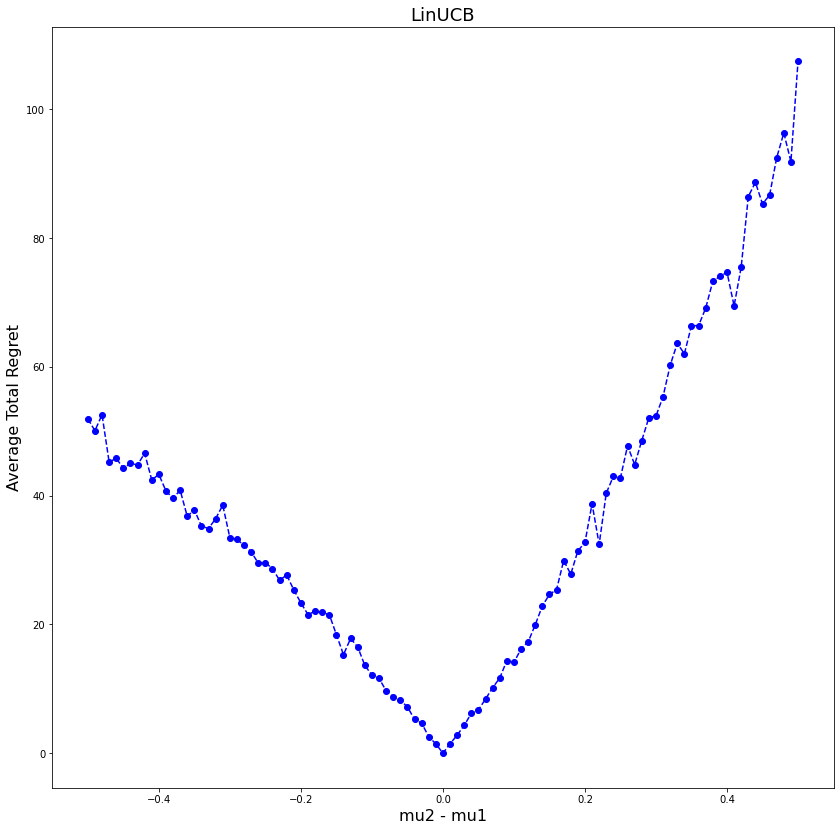

In [318]:
fig, ax = plt.subplots()
fig.set_figheight(14)
fig.set_figwidth(14)
plt.plot(theta1,x['point'],"--bo",color='blue')
#plt.plot(mu2,df2['point'],"--bo",color='green')
#plt.plot(mu2,df33['point'],"--bo",color='red')
#plt.plot(sim44['mu1'],sim44['regret'],"--bo",color='black')

ax.set_title("LinUCB",fontsize=18)
ax.set_xlabel('mu2 - mu1', fontsize=16)
ax.set_ylabel('Average Total Regret', fontsize=16)
#plt.legend(['[1,1]', '[1,3]','[10,10]','[10,30]'],prop={'size': 18})
#ax.tick_params(axis='both', which='major', labelsize=16)

In [296]:
x

,point,var
0,93.7300,37.154100
1,84.4662,195.970484
2,80.5536,677.760215
3,67.4920,845.477962
4,64.8876,1111.792190
...,...,...
96,11.5736,319.828829
97,16.7320,367.925738
98,30.7008,751.356150
99,20.0998,691.454290


# Simulation Runs

In [145]:
df_ETC_1

,mu2,25point,25error,50point,50error,75point,75error,100point,100error,1000point,1000error
0,0.01,5.0475,0.150276,4.937,0.142360,4.5835,0.133817,4.856,0.126472,4.90020,1.578450e-01
1,0.02,9.5250,0.300191,9.316,0.283924,9.3540,0.268150,9.488,0.252590,9.70060,3.156111e-01
2,0.03,14.1165,0.449983,13.137,0.423035,13.2150,0.399419,13.368,0.376136,14.58084,4.734441e-01
3,0.04,18.2520,0.598584,17.480,0.563886,16.6680,0.527424,16.000,0.490143,20.19960,6.314749e-01
4,0.05,21.2950,0.742217,19.510,0.690352,20.1550,0.654612,19.360,0.607091,24.60080,7.892820e-01
...,...,...,...,...,...,...,...,...,...,...,...
95,0.96,24.0000,0.000000,48.000,0.000000,72.0000,0.000000,96.000,0.000000,23.95392,9.139200e-01
96,0.97,24.2500,0.000000,48.500,0.000000,72.7500,0.000000,97.000,0.000000,23.28000,2.248058e-16
97,0.98,24.5000,0.000000,49.000,0.000000,73.5000,0.000000,98.000,0.000000,23.47492,9.349200e-01
98,0.99,25.6905,0.940500,49.500,0.000000,74.2500,0.000000,99.000,0.000000,22.77000,0.000000e+00


In [206]:
mu2_fast = [0.01*i for i in range(0,101,10)]

In [233]:
UCB_KL(n=1000,mu2=0.4,gaussian=1)

0

In [168]:
# Simulation Runs

# ETC 
mu2 = [0.01*i for i in range(1,101)]
m = [25,50,75,100,1000]
df_ETC_1 = simulationN(mu2,m,gaussian=1,num_sim=1000)
df_ETC_2 = simulationN(mu2,m,gaussian=2,num_sim=1000)

 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:13<00:07,  4.85it/s]


 28%|██████████████████████▋                                                          | 28/100 [00:11<00:27,  2.60it/s]


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:38<00:02,  2.62it/s]


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:33<00:24,  1.72it/s]


 22%|█████████████████▊                                                               | 22/100 [00:17<01:02,  1.24it/s]


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [01:07<00:11,  1.05it/s]


 58%|██████████████████████████████████████████████▉                                  | 58/100 [01:02<00:22,  1.91it/s]


 21%|█████████████████                                                                | 21/100 [00:04<00:16,  4.77it/s]


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:18<00:02,  4.74it/s]


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:18<00:17,  2.75it/s]


 15%|████████████▏                                                                    | 15/100 [00:07<00:44,  1.92it/s]


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:45<00:10,  1.82it/s]


 45%|████████████████████████████████████▍                                            | 45/100 [00:31<00:37,  1.45it/s]


 14%|███████████▎                                                                     | 14/100 [00:17<02:42,  1.89s/it]


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [01:03<00:05,  3.70it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:11<00:00, 50.24s/it]


In [170]:
%store df_ETC_1
%store df_ETC_2

Stored 'df_ETC_1' (DataFrame)
Stored 'df_ETC_2' (DataFrame)


In [11]:
mu2 = [0.01*x for x in range(101)]

In [234]:
df = simulationN_standard(mu2) 

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [2:19:09<00:00, 83.50s/it]


In [235]:
%store df

Stored 'df' (DataFrame)


In [242]:
df2 = simulationN_asymptotic(mu2) 

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [2:45:36<00:00, 99.37s/it]


In [243]:
%store df2

Stored 'df2' (DataFrame)


In [244]:
df3 = simulationN_moss(mu2) 

  0%|                                                                                          | 0/100 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
df_ber = simulationN_standard(mu2,gaussian=2)
%store df_ber

In [ ]:
%store df3

In [207]:
df4 = simulationN_KL(mu2_fast,num_sim=1000)

 18%|██████████████▌                                                                 | 2/11 [14:16<1:04:13, 428.19s/it]


KeyboardInterrupt: 

In [203]:
df4

,point,var
0,0.0000,0.000000
1,4.5090,1996.593219
2,23.9720,8987.021616
3,14.0630,4682.908881
4,38.9040,10098.687384
5,20.1325,4575.066819
6,24.4660,4171.557644
7,35.9625,4080.225769
8,20.0540,1585.885884
9,15.4470,527.938891


# Plots

Text(0, 0.5, 'Average Total Regret')

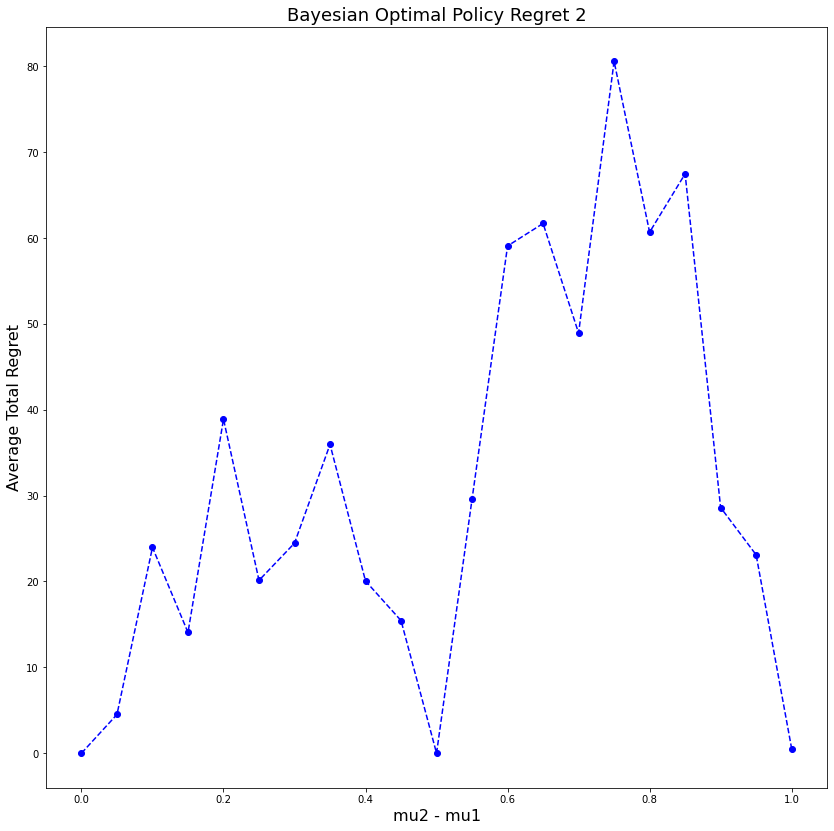

In [205]:
fig, ax = plt.subplots()
fig.set_figheight(14)
fig.set_figwidth(14)
plt.plot(mu2_fast,df4['point'],"--bo",color='blue')
#plt.plot(mu2,df2['point'],"--bo",color='green')
#plt.plot(mu2,df33['point'],"--bo",color='red')
#plt.plot(sim44['mu1'],sim44['regret'],"--bo",color='black')

ax.set_title("Bayesian Optimal Policy Regret 2",fontsize=18)
ax.set_xlabel('mu2 - mu1', fontsize=16)
ax.set_ylabel('Average Total Regret', fontsize=16)
#plt.legend(['[1,1]', '[1,3]','[10,10]','[10,30]'],prop={'size': 18})
#ax.tick_params(axis='both', which='major', labelsize=16)

Text(0, 0.5, 'Average Total Regret')

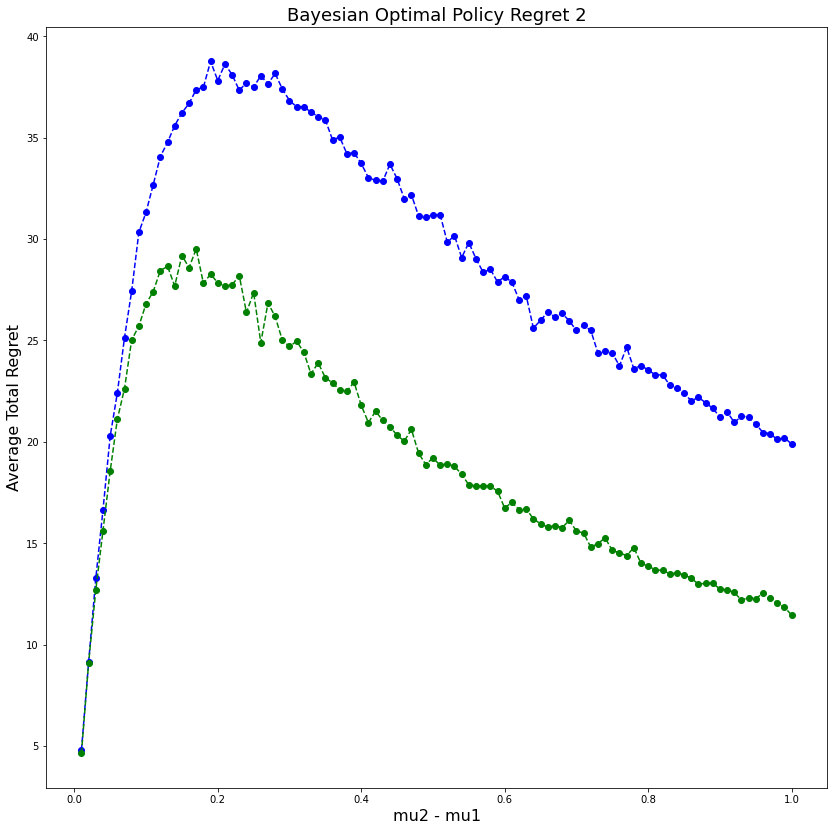

In [245]:
fig, ax = plt.subplots()
fig.set_figheight(14)
fig.set_figwidth(14)
plt.plot(mu2,df['point'],"--bo",color='blue')
plt.plot(mu2,df2['point'],"--bo",color='green')
#plt.plot(mu2,df33['point'],"--bo",color='red')
#plt.plot(sim44['mu1'],sim44['regret'],"--bo",color='black')

ax.set_title("Bayesian Optimal Policy Regret 2",fontsize=18)
ax.set_xlabel('mu2 - mu1', fontsize=16)
ax.set_ylabel('Average Total Regret', fontsize=16)
#plt.legend(['[1,1]', '[1,3]','[10,10]','[10,30]'],prop={'size': 18})
#ax.tick_params(axis='both', which='major', labelsize=16)